In [2]:
from utilities import *
import audio_features_utils
import threading

Using TensorFlow backend.


# SET CONSTANT

In [3]:
DATA_DIR_PATH = '../dataset/vctk/VCTK-Corpus/wav48/'
N_MFCC = 40
SR = 16000
AUDIO_LENGTH = 3 # seconds

# PREPARATION

In [4]:
def load_audio_and_resample(path):
    rate, audio = wavfile.read(path)
    audio = audio.astype(float)
    if len(audio.shape) > 1:
        audio = np.mean(audio, axis=-1)
    audio = librosa.core.resample(audio, rate, SR)
    return audio

def preprocess(audio, st='random'):
    assert st =='random' or type(st) == range, 'range has to be \'random\' or type range'
    length = int(SR*AUDIO_LENGTH)
    if len(audio) < length:
        temp = np.zeros((length,))
        temp[:len(audio)] = audio
        audio = temp
    elif st =='random':
        start_idx = np.random.randint(0, len(audio) - length)
        audio = audio[start_idx: start_idx+length]
    else:
        audio = audio[st: st+length] 
        
    return librosa.feature.mfcc(audio, sr=SR, n_mfcc=N_MFCC)

In [5]:
speakers = os.listdir(DATA_DIR_PATH)
speaker_to_label = dict()
for speaker in speakers:
    speaker_to_label[speaker] = len(speaker_to_label)

In [6]:
TEST_SIZE = 0.2
VAL_SIZE = 0.1
RANDOM_SEED = 99

In [7]:
data = pd.DataFrame(columns=['filename','label','mode'])
counts = dict()
for speaker in speakers:
    fnames = os.listdir(DATA_DIR_PATH+speaker)
    counts[speaker] = len(fnames)
    train, test = train_test_split(fnames, test_size=TEST_SIZE, random_state=RANDOM_SEED)
    train, val = train_test_split(train, test_size=VAL_SIZE, random_state=RANDOM_SEED)
    
    temp = pd.DataFrame(np.transpose([
        train, 
        [speaker_to_label[speaker]]*len(train), 
        ['train']*len(train),
    ]),columns=['filename', 'label','mode'])
        
    data = data.append(temp, ignore_index=True)
    
    temp = pd.DataFrame(np.transpose([
        test, 
        [speaker_to_label[speaker]]*len(test), 
        ['test']*len(test)
    ]),columns=['filename', 'label','mode'])
        
    data = data.append(temp, ignore_index=True)
    
    temp = pd.DataFrame(np.transpose([
        val, 
        [speaker_to_label[speaker]]*len(val), 
        ['val']*len(val)
    ]),columns=['filename', 'label','mode'])
        
    data = data.append(temp, ignore_index=True)

In [8]:
# audios = []
# for filename in tqdm(data['filename']):
#     to_path = lambda speaker, filename: f'{DATA_DIR_PATH}{speaker}/{filename}'
#     path = to_path(filename[:4],filename)
#     audios.append(load_audio_and_resample(path))
# data['audio'] = audios
audios_path = '../parsed_data/vctk/np_audios/'
data['audio'] = np.concatenate([
    np.load(audios_path+'np_audios1.npy', allow_pickle=True),
    np.load(audios_path+'np_audios2.npy', allow_pickle=True),
    np.load(audios_path+'np_audios3.npy', allow_pickle=True),
    np.load(audios_path+'np_audios4.npy', allow_pickle=True),
])

min:  172 max:  503


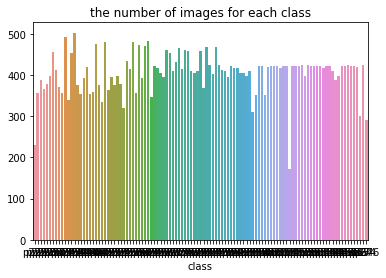

In [9]:
fig, ax = plt.subplots()
sns.barplot(list(counts.keys()), list(counts.values()))
ax.set_title("the number of images for each class")
ax.set_xlabel("class")
print('min: ',min(counts.values()), 'max: ',max(counts.values()))

# SAMPLE

In [10]:
sample_audio = data['audio'][0]
sample_mfcc = preprocess(sample_audio)

In [11]:
Audio(sample_audio, rate=16000)

In [12]:
data_shape = sample_mfcc.shape
data_shape

(40, 94)

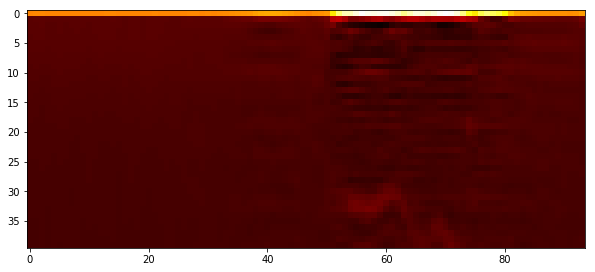

In [13]:
temp = preprocess(load_audio_and_resample(DATA_DIR_PATH+data['filename'][0][:4]+'/'+data['filename'][0]))
plt.figure(figsize=(10,10))
plt.imshow(temp, cmap='hot')

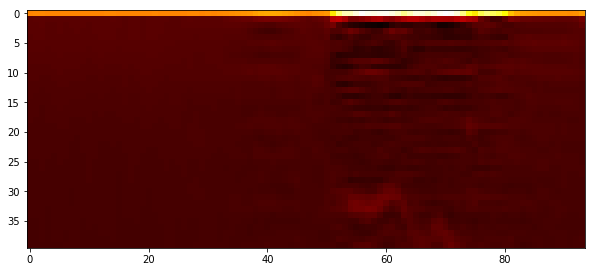

In [14]:
plt.figure(figsize=(10,10))
plt.imshow(sample_mfcc, cmap='hot')

# DATA GENERATOR

In [33]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, mode, sr=16000, times=3, batch_size=200, random_state=99, shuffle=True, train=True):
        self.mode = mode
        self.sr = sr
        self.times = times
        self.batch_size = batch_size
        self.df = data[data['mode'] == mode]
        self.train = train
        
        self.shuffle = shuffle
        self.random_state = random_state
        np.random.seed(self.random_state)
        
        self.indexes = np.array(self.df.index) 
        
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.floor(len(self.df)/self.batch_size))
    
    def __getitem__(self, index):
        indexes = self.__generate_batch_idxes(index)        
        if self.train:
            return self.__generate_X(indexes),self.__generate_y(indexes)
        else:
            return self.__generate_X(indexes)
    
    def __generate_batch_idxes(self, index):
        return self.indexes[index*self.batch_size:(index+1)*self.batch_size]
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)
            
    def __generate_X(self, indexes):
        X = np.zeros((self.batch_size,)+data_shape, dtype=np.float16)
        for i, idx in enumerate(indexes):
            X[i] = preprocess(self.df['audio'][idx])
        return X
    
    def __generate_y(self, indexes):
        return np.array(self.df['label'].loc[indexes])

# MODEL

In [21]:
def feature_extractor13(name='feature_extractor', dup=0):
    def Conv(f, k, s, inp):
        inner = Conv1D(f, k, strides=s, padding='same')(inp)
        inner = BatchNormalization()(inner)
        inner = Activation(swish)(inner)
        return inner
        
    features = data_shape[0]
    input_layer = Input(data_shape, name='i1')
    inner = Lambda(lambda x: tf.transpose(x, [0,2,1]))(input_layer)
    inner = BatchNormalization(name='b1')(inner)
    
    features=64
    inner = Conv(features, 5, 2, inner)
    inner1 = Multiply()([gate(inner, 'sigmoid'), inner])
    inner = Conv1D(features, 7, padding='same')(inner)
    inner = Conv1D(features, 7, padding='same')(inner)
    inner = Multiply()([gate(inner, 'sigmoid'), inner])
    inner = Add()([inner1, inner])
    inner = BatchNormalization()(inner)
    inner = Activation(swish)(inner)
    
    inner1, inner2 = Lambda(lambda x: tf.split(x, 2, axis=-1))(inner)
    
    inner1 = Flatten()(inner1)
    inner1 = Dense(512)(inner1)
    
    inner2 = Flatten()(inner2)
    inner2 = Dense(512, activation='softmax')(inner2)
    
    inner = Multiply()([inner1, inner2])
    inner = BatchNormalization()(inner)
    output_layer = Dense(512, activation=swish)(inner)

    if not dup:
        return keras.models.Model(inputs=input_layer, outputs=output_layer, name=name)
    else:
        temp = []
        for i in range(dup+1):
            temp.append(keras.models.Model(inputs=input_layer, outputs=output_layer, name=name+'_'+str(i)))
        return temp

def full_model1():
    input_layer1 = Input(data_shape)
    fe = feature_extractor13()
    
    f1 = fe(input_layer1)
    f1 = Dropout(0.5)(f1)
    output_layer1 = Dense(len(speakers), activation='softmax', name='classifier')(f1)
    classifier = keras.models.Model(inputs=input_layer1, outputs=output_layer1, name='classifier')
    return classifier

# CALLBACKS

In [27]:
# model_name = 'combinerg42s-mse'
model_name = '01ss'
# model_path = 'D:/code/datasets/sound-trans/models/vctkv2/'+model_name+'/'
model_path = '../models/vctkv2/'+model_name+'/'

checkpoints_filenames = "weights-{val_loss:.4f}.hdf5"
checkpoints = keras.callbacks.ModelCheckpoint(model_path+checkpoints_filenames, monitor='val_loss', save_weights_only=True, period=2)
csv_logger = keras.callbacks.CSVLogger(model_path+'model.log', append=True)

rlr = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, verbose=1)
er = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=5, verbose=1)

callback_list = [checkpoints,csv_logger, rlr, Logger(5), er]

# TRAIN

In [23]:
model = full_model1()
model.summary()

W1010 18:19:37.256423 10456 deprecation_wrapper.py:119] From c:\program files\python36\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1010 18:19:37.284428 10456 deprecation_wrapper.py:119] From c:\program files\python36\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1010 18:19:37.341432 10456 deprecation_wrapper.py:119] From c:\program files\python36\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1010 18:19:37.366961 10456 deprecation_wrapper.py:119] From c:\program files\python36\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1010 18:19:38.082332 10456 deprecation.py

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 40, 94)            0         
_________________________________________________________________
feature_extractor (Model)    (None, 512)               1885152   
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
classifier (Dense)           (None, 109)               55917     
Total params: 1,941,069
Trainable params: 1,939,709
Non-trainable params: 1,360
_________________________________________________________________


In [24]:
optimizer = keras.optimizers.Adam()

In [25]:
model.compile(optimizer, 'sparse_categorical_crossentropy', ['acc'])

W1010 18:19:42.679735 10456 deprecation_wrapper.py:119] From c:\program files\python36\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1010 18:19:42.686721 10456 deprecation_wrapper.py:119] From c:\program files\python36\lib\site-packages\keras\backend\tensorflow_backend.py:3341: The name tf.log is deprecated. Please use tf.math.log instead.



In [26]:
model.load_weights('../models/vctkv2/01/weights-0.0889.hdf5')

In [34]:
BATCH_SIZE = 300
EPOCHS = 24

train_generator = DataGenerator('train', sr=SR, times=AUDIO_LENGTH, batch_size=BATCH_SIZE, random_state=RANDOM_SEED)
test_generator = DataGenerator('test', sr=SR, times=AUDIO_LENGTH, batch_size=BATCH_SIZE, random_state=RANDOM_SEED)

if not os.path.isdir(model_path):
    os.mkdir(model_path)
    
hist = model.fit_generator(
    train_generator,
    epochs=EPOCHS,
    verbose=0,
    validation_data=test_generator,
    callbacks=callback_list
)

For batch 0 on 0, loss:   0.023, acc:   0.993
For batch 5 on 1500, loss:   0.023, acc:   0.995
For batch 10 on 3000, loss:   0.058, acc:   0.989
For batch 15 on 4500, loss:   0.029, acc:   0.992
For batch 20 on 6000, loss:   0.032, acc:   0.991
For batch 25 on 7500, loss:   0.037, acc:   0.989
For batch 30 on 9000, loss:   0.048, acc:   0.986
For batch 35 on 10500, loss:   0.037, acc:   0.987
For batch 40 on 12000, loss:   0.049, acc:   0.991
For batch 45 on 13500, loss:   0.060, acc:   0.985
For batch 50 on 15000, loss:   0.038, acc:   0.987
For batch 55 on 16500, loss:   0.043, acc:   0.989
For batch 60 on 18000, loss:   0.043, acc:   0.989
For batch 65 on 19500, loss:   0.042, acc:   0.984
For batch 70 on 21000, loss:   0.032, acc:   0.993
For batch 75 on 22500, loss:   0.035, acc:   0.991
For batch 80 on 24000, loss:   0.024, acc:   0.991
For batch 85 on 25500, loss:   0.026, acc:   0.991
For batch 90 on 27000, loss:   0.048, acc:   0.984
For batch 95 on 28500, loss:   0.057, acc: 

For batch 20 on 6000, loss:   0.034, acc:   0.993, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 25 on 7500, loss:   0.025, acc:   0.991, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 30 on 9000, loss:   0.029, acc:   0.991, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 35 on 10500, loss:   0.039, acc:   0.989, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 40 on 12000, loss:   0.031, acc:   0.993, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 45 on 13500, loss:   0.022, acc:   0.993, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 50 on 15000, loss:   0.029, acc:   0.993, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 55 on 16500, loss:   0.017, acc:   0.995, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 60 on 18000, loss:   0.034, acc:   0.991, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 65 on 19500, loss:   0.035, acc:   0.990, val_loss:   0.000, val_acc:   0.000, lr:  

For batch 95 on 28500, loss:   0.012, acc:   0.997, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 100 on 30000, loss:   0.005, acc:   0.999, val_loss:   0.000, val_acc:   0.000, lr:   0.000
Epoch 7 , val_loss:   0.027, val_acc:   0.992, loss:   0.011, acc:   0.997, lr:   0.001
For batch 0 on 0, loss:   0.005, acc:   1.000, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 5 on 1500, loss:   0.007, acc:   0.999, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 10 on 3000, loss:   0.008, acc:   0.998, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 15 on 4500, loss:   0.008, acc:   0.997, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 20 on 6000, loss:   0.007, acc:   0.999, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 25 on 7500, loss:   0.009, acc:   0.997, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 30 on 9000, loss:   0.009, acc:   0.998, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 35 o

For batch 65 on 19500, loss:   0.008, acc:   0.997, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 70 on 21000, loss:   0.011, acc:   0.997, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 75 on 22500, loss:   0.007, acc:   0.997, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 80 on 24000, loss:   0.009, acc:   0.997, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 85 on 25500, loss:   0.009, acc:   0.997, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 90 on 27000, loss:   0.008, acc:   0.997, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 95 on 28500, loss:   0.006, acc:   0.997, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 100 on 30000, loss:   0.008, acc:   0.997, val_loss:   0.000, val_acc:   0.000, lr:   0.000

Epoch 00012: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 11 , val_loss:   0.029, val_acc:   0.993, loss:   0.007, acc:   0.998, lr:   0.001
For batch 0 on 0, los

For batch 30 on 9000, loss:   0.002, acc:   1.000, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 35 on 10500, loss:   0.001, acc:   1.000, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 40 on 12000, loss:   0.006, acc:   0.997, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 45 on 13500, loss:   0.003, acc:   0.998, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 50 on 15000, loss:   0.003, acc:   1.000, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 55 on 16500, loss:   0.006, acc:   0.999, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 60 on 18000, loss:   0.004, acc:   0.999, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 65 on 19500, loss:   0.003, acc:   0.999, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 70 on 21000, loss:   0.003, acc:   0.999, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 75 on 22500, loss:   0.004, acc:   0.999, val_loss:   0.000, val_acc:   0.000, lr:

Epoch 18 , val_loss:   0.017, val_acc:   0.996, loss:   0.004, acc:   0.999, lr:   0.000
For batch 0 on 0, loss:   0.000, acc:   1.000, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 5 on 1500, loss:   0.002, acc:   1.000, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 10 on 3000, loss:   0.004, acc:   0.999, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 15 on 4500, loss:   0.005, acc:   0.999, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 20 on 6000, loss:   0.008, acc:   0.999, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 25 on 7500, loss:   0.005, acc:   0.998, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 30 on 9000, loss:   0.001, acc:   1.000, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 35 on 10500, loss:   0.001, acc:   1.000, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 40 on 12000, loss:   0.003, acc:   0.999, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 45 o

For batch 75 on 22500, loss:   0.000, acc:   1.000, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 80 on 24000, loss:   0.001, acc:   1.000, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 85 on 25500, loss:   0.010, acc:   0.999, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 90 on 27000, loss:   0.002, acc:   0.999, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 95 on 28500, loss:   0.001, acc:   1.000, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 100 on 30000, loss:   0.000, acc:   1.000, val_loss:   0.000, val_acc:   0.000, lr:   0.000

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
Epoch 22 , val_loss:   0.016, val_acc:   0.996, loss:   0.003, acc:   0.999, lr:   0.000
For batch 0 on 0, loss:   0.001, acc:   1.000, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 5 on 1500, loss:   0.001, acc:   1.000, val_loss:   0.000, val_acc:   0.000, lr:   0.000
For batch 10 on 3000, loss: 

In [35]:
model.evaluate_generator(DataGenerator('val'))

[0.0257811456480447, 0.9932353005689734]

In [36]:
model.evaluate_generator(DataGenerator('test'))

[0.015254793637061746, 0.9951136410236359]